In [7]:
# ============================================================================
# HULL TACTICAL MARKET PREDICTION - EXPLORATORY DATA ANALYSIS
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# 1. LOAD DATA (CHANGE PATHS IF LOCAL RUN)
# ============================================================================

train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

Train shape: (9021, 98)
Test shape: (10, 99)


In [8]:
# ============================================================================
# 2. DATA OVERVIEW
# ============================================================================

# Basic info
print("Column types:")
print(train_df.dtypes.value_counts())
print(f"\nTotal missing values: {train_df.isnull().sum().sum()}")

Column types:
float64    88
int64      10
Name: count, dtype: int64

Total missing values: 137675


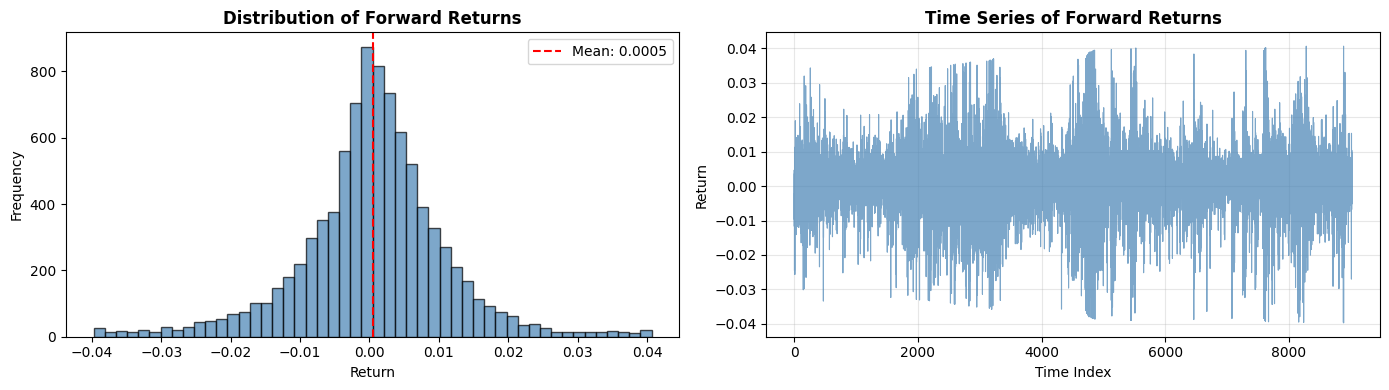


TARGET VARIABLE STATISTICS
Mean:     0.000471
Std Dev:  0.010541
Min:      -0.039754
Max:      0.040661
Skewness: -0.1782
Kurtosis: 2.1979


In [9]:
# ============================================================================
# 3. TARGET VARIABLE ANALYSIS
# ============================================================================

target = 'forward_returns'

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Distribution
axes[0].hist(train_df[target], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_title('Distribution of Forward Returns', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Return')
axes[0].set_ylabel('Frequency')
axes[0].axvline(train_df[target].mean(), color='red', linestyle='--', label=f"Mean: {train_df[target].mean():.4f}")
axes[0].legend()

# Time series
axes[1].plot(train_df[target].values, linewidth=0.8, alpha=0.7, color='steelblue')
axes[1].set_title('Time Series of Forward Returns', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Time Index')
axes[1].set_ylabel('Return')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("TARGET VARIABLE STATISTICS")
print("="*60)
print(f"Mean:     {train_df[target].mean():.6f}")
print(f"Std Dev:  {train_df[target].std():.6f}")
print(f"Min:      {train_df[target].min():.6f}")
print(f"Max:      {train_df[target].max():.6f}")
print(f"Skewness: {stats.skew(train_df[target]):.4f}")
print(f"Kurtosis: {stats.kurtosis(train_df[target]):.4f}")

# Forward returns are normally distributed with slight left skew.
# Positive mean (0.047%) suggests upward bias. Standard deviation (1.054%) 
# indicates daily volatility similar to market benchmark.

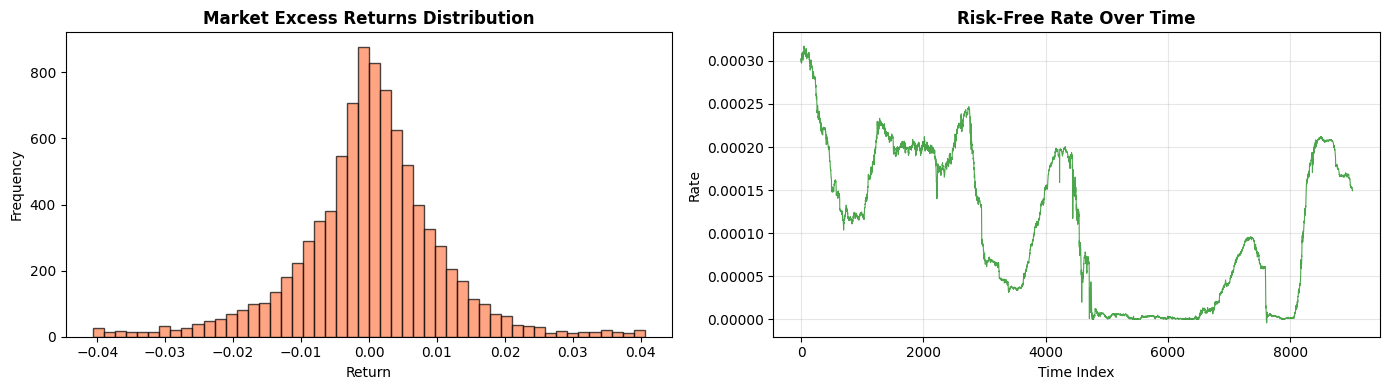


BENCHMARK & RISK-FREE RATE STATISTICS
Market Return Mean:   0.000053
Market Return Std:    0.010558
Risk-Free Rate Mean:  0.000107


In [10]:
# ============================================================================
# 4. BENCHMARK & RISK-FREE RATE
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Benchmark returns
market_col = 'market_forward_excess_returns'
axes[0].hist(train_df[market_col], bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[0].set_title('Market Excess Returns Distribution', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Return')
axes[0].set_ylabel('Frequency')

# Risk-free rate
axes[1].plot(train_df['risk_free_rate'].values, linewidth=0.8, alpha=0.7, color='green')
axes[1].set_title('Risk-Free Rate Over Time', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Time Index')
axes[1].set_ylabel('Rate')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("BENCHMARK & RISK-FREE RATE STATISTICS")
print("="*60)
print(f"Market Return Mean:   {train_df[market_col].mean():.6f}")
print(f"Market Return Std:    {train_df[market_col].std():.6f}")
print(f"Risk-Free Rate Mean:  {train_df['risk_free_rate'].mean():.6f}")

# Market benchmark has similar volatility (1.056%) to target.
# Our model must beat this baseline. Risk-free rate is near zero (low interest environment).

In [11]:
# ============================================================================
# 6. MISSING DATA ANALYSIS
# ============================================================================

print("\n" + "="*60)
print("MISSING VALUES")
print("="*60)
missing_pct = (train_df.isnull().sum() / len(train_df) * 100).sort_values(ascending=False)
missing_pct = missing_pct[missing_pct > 0]
    
print(f"Features with <10% missing: {len(missing_pct[missing_pct < 10])}")
print(f"Features with 10-30% missing: {len(missing_pct[(missing_pct >= 10) & (missing_pct < 30)])}")
print(f"Features with >30% missing: {len(missing_pct[missing_pct >= 30])}")



MISSING VALUES
Features with <10% missing: 0
Features with 10-30% missing: 73
Features with >30% missing: 12



TIME-SERIES CHARACTERISTICS
Total time steps: 9021
Time span: date_id 0 to 9020
Average daily return: 0.000471
Daily volatility: 0.010541


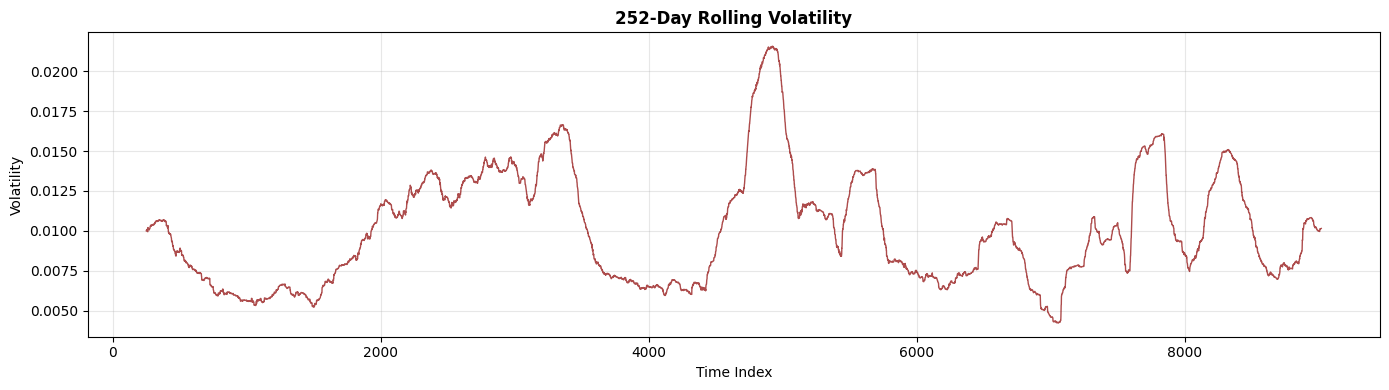

Rolling volatility mean: 0.009983
Rolling volatility range: [0.004240, 0.021566]


In [12]:
# ============================================================================
# 7. TIME-SERIES CHARACTERISTICS
# ============================================================================

print("\n" + "="*60)
print("TIME-SERIES CHARACTERISTICS")
print("="*60)
print(f"Total time steps: {len(train_df)}")
print(f"Time span: date_id {train_df['date_id'].min()} to {train_df['date_id'].max()}")
print(f"Average daily return: {train_df[target].mean():.6f}")
print(f"Daily volatility: {train_df[target].std():.6f}")

# Calculate rolling volatility
rolling_vol = train_df[target].rolling(252).std()

fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(rolling_vol.values, linewidth=1, alpha=0.7, color='darkred')
ax.set_title('252-Day Rolling Volatility', fontsize=12, fontweight='bold')
ax.set_xlabel('Time Index')
ax.set_ylabel('Volatility')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Rolling volatility mean: {rolling_vol.mean():.6f}")
print(f"Rolling volatility range: [{rolling_vol.min():.6f}, {rolling_vol.max():.6f}]")

# Features selection
## Analyzing missing values

In [24]:
# Analyze missing values across features
missing_info = []

excluded_cols = [
    'date_id', 
    'forward_returns', 
    'risk_free_rate', 
    'market_forward_excess_returns'
]

for col in train_df.columns:
    if col in excluded_cols:
        continue
    
    missing_count = train_df[col].isnull().sum()
    if missing_count == 0:
        continue
    
    missing_pct = (missing_count / len(train_df)) * 100
    first_valid_idx = train_df[col].first_valid_index()
    
    missing_info.append({
        'feature': col,
        'missing_count': missing_count,
        'missing_pct': missing_pct,
        'first_valid_idx': first_valid_idx,
        'group': col[0]
    })

missing_df = (
    pd.DataFrame(missing_info)
    .sort_values('missing_pct', ascending=False)
)

# Summary
print("\nMissing Data Summary:")
total_features = len([c for c in train_df.columns if c not in excluded_cols])
print(f"  Total features analyzed: {total_features}")
print(f"  Features with missing values: {len(missing_df)}")
print(f"  Features >30% missing: {(missing_df['missing_pct'] > 30).sum()}")
print(f"  Features >80% missing: {(missing_df['missing_pct'] > 80).sum()}")

# Features with too many missing values
print("\n Features to get automatically rid of")
print((missing_df[missing_df['missing_pct'] > 30]).to_string)


Missing Data Summary:
  Total features analyzed: 94
  Features with missing values: 85
  Features >30% missing: 12
  Features >80% missing: 0

 Features to get automatically rid of
<bound method DataFrame.to_string of    feature  missing_count  missing_pct  first_valid_idx group
17      E7           6969    77.253076             6969     E
73     V10           6049    67.054650             6049     V
65      S3           5733    63.551713             5733     S
29      M1           5547    61.489857             5547     M
34     M14           5540    61.412260             5540     M
33     M13           5540    61.412260             5540     M
43      M6           5043    55.902893             5043     M
84      V9           4539    50.315929             4539     V
63     S12           3537    39.208513             3537     S
42      M5           3283    36.392861             3283     M
39      M2           3217    35.661235             3217     M
70      S8           3009    33.35550

In [25]:
df = train_df.copy()

TARGET = "market_forward_excess_returns"

# Remove columns we don't want
drop_cols = ["forward_returns", "risk_free_rate", "date_id"]
df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore")

# Select only numeric columns except target
features = [
    c for c in df.columns
    if c != TARGET and pd.api.types.is_numeric_dtype(df[c])
]

#filter features with <30% missing
missing_ratio = df[features].isnull().mean()
features = [c for c in features if missing_ratio[c] < 0.30]

print(f"Using {len(features)} features for the heatmap.")

Using 82 features for the heatmap.


## Studying features correlation over time

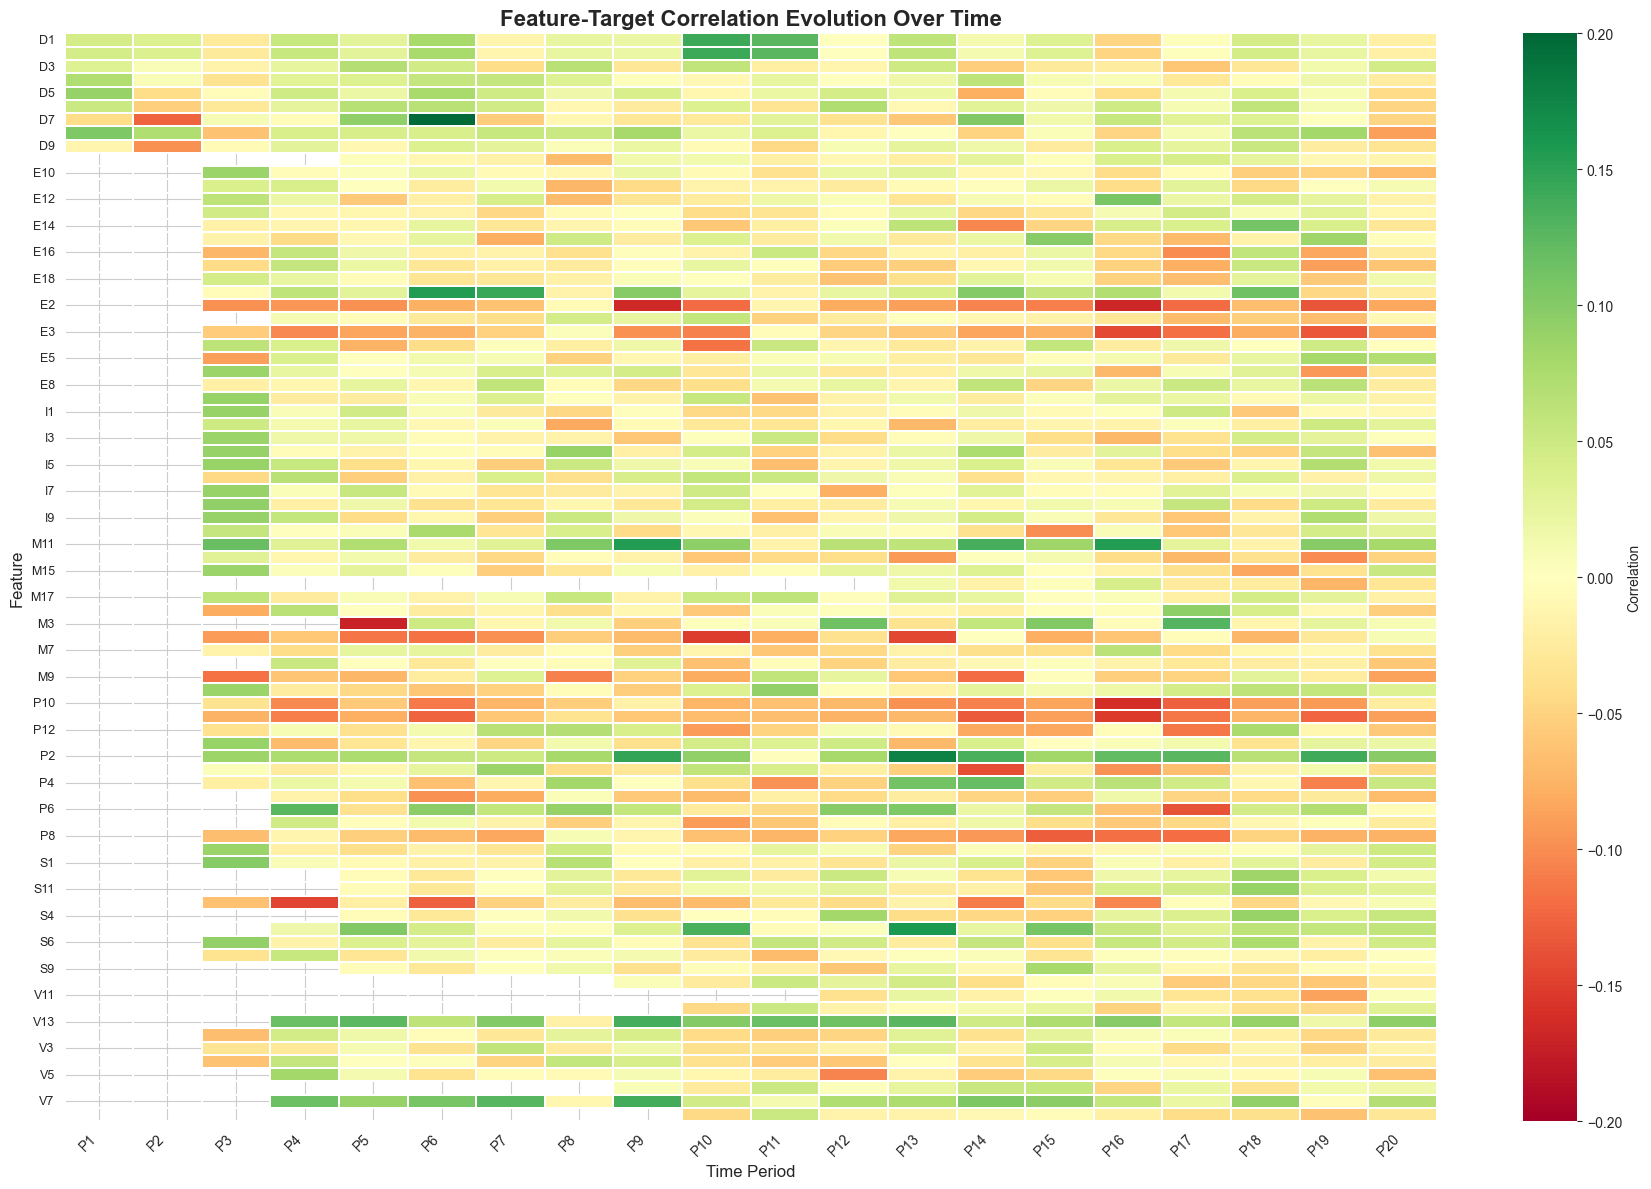

In [26]:
# ---------------------------------------------
# Compute correlation evolution matrix
# ---------------------------------------------
from scipy.stats import pearsonr

n_time_bins = 20
time_bin_size = len(df) // n_time_bins

corr_matrix = np.full((len(features), n_time_bins), np.nan)

for i, feature in enumerate(features):
    for j in range(n_time_bins):

        start_idx = j * time_bin_size
        end_idx = (j + 1) * time_bin_size if j < n_time_bins - 1 else len(df)

        period_data = df.iloc[start_idx:end_idx]
        valid_mask = period_data[feature].notna()

        if valid_mask.sum() > 30:
            corr, _ = pearsonr(
                period_data.loc[valid_mask, feature],
                period_data.loc[valid_mask, TARGET]
            )
            corr_matrix[i, j] = corr


# ---------------------------------------------
# Build dataframe for seaborn
# ---------------------------------------------
period_labels = [f"P{i+1}" for i in range(n_time_bins)]

corr_df = pd.DataFrame(
    corr_matrix,
    index=features,
    columns=period_labels
)


# ---------------------------------------------
# Plot heatmap with seaborn
# ---------------------------------------------
plt.figure(figsize=(18, 12))
sns.set_style("whitegrid")

ax = sns.heatmap(
    corr_df,
    cmap="RdYlGn",
    center=0,
    vmin=-0.2,
    vmax=0.2,
    linewidths=0.3,
    linecolor="white",
    cbar_kws={"label": "Correlation"},
    mask=corr_df.isna(),
)

plt.title("Feature-Target Correlation Evolution Over Time", fontsize=16, fontweight="bold")
plt.xlabel("Time Period", fontsize=12)
plt.ylabel("Feature", fontsize=12)

plt.xticks(rotation=45, ha="right")
plt.yticks(fontsize=9)

plt.tight_layout()
plt.show()

 ## We can see that features' correlation evolve over time, so it might be worth considering using a dynamic model which changes related to which time period it is predicting for during test time.

# Feature Selection

In [29]:
# ======================================================
# 0. Setup
# ======================================================
from scipy.stats import spearmanr
from sklearn.model_selection import TimeSeriesSplit
from lightgbm import LGBMRegressor

TARGET = "market_forward_excess_returns"
N_PERIODS = 20          # time bins for correlation evolution
MAX_MISSING = 0.30      # max allowed missing ratio per feature
N_SPLITS = 4            # folds for TimeSeriesSplit
PRED_BOUNDS = (-0.05, 0.05)  # to adjust predictions
MAX_VOL_RATIO = 1.2

# category quotas (to make sure we take into account distinct parameters)
CATEGORY_QUOTAS = {
    "E": 5,   # Macro
    "S": 3,   # Sentiment
    "V": 4,   # Volatility
    "I": 2,   # Interest rates
    "M": 3,   # Market / momentum
    "P": 3,   # Price / valuation
}

df = train_df.copy()

# Drop non-features
drop_cols = ["forward_returns", "risk_free_rate", "date_id"]
df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore")

# ======================================================
# 1. Filter features (numeric, <= MAX_MISSING)
# ======================================================
all_feats = [c for c in df.columns if c != TARGET and pd.api.types.is_numeric_dtype(df[c])]

missing_ratio = df[all_feats].isnull().mean()
good_feats = [c for c in all_feats if missing_ratio[c] <= MAX_MISSING]

print(f"Features candidates after missing filter: {len(good_feats)}")


# Convenience
X_all = df[good_feats].values
y_all = df[TARGET].values

# ======================================================
# 2. Correlation evolution + robust correlation score
# ======================================================
n = len(df)
period_size = n // N_PERIODS

corr_evolution = {feat: [] for feat in good_feats}

for feat in good_feats:
    for p in range(N_PERIODS):
        start = p * period_size
        end = (p + 1) * period_size if p < N_PERIODS - 1 else n

        chunk = df.iloc[start:end]
        valid = chunk[feat].notna()

        if valid.sum() > 30:
            corr, _ = spearmanr(
                chunk.loc[valid, feat],
                chunk.loc[valid, TARGET]
            )
        else:
            corr = np.nan
        corr_evolution[feat].append(corr)

corr_df = pd.DataFrame(corr_evolution).T  # index = features, cols = P1..P20

# mean |corr| et stabilité
mean_abs_corr = corr_df.abs().mean(axis=1)
corr_var = corr_df.var(axis=1, skipna=True)
corr_stability = 1.0 / (corr_var + 1e-6)

robust_corr_score = mean_abs_corr * corr_stability

# ======================================================
# 3. LightGBM importance with TimeSeriesSplit
# ======================================================
tscv = TimeSeriesSplit(n_splits=N_SPLITS)

lgb_importances = np.zeros(len(good_feats))

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_all, y_all), 1):
    X_tr, X_val = X_all[train_idx], X_all[val_idx]
    y_tr, y_val = y_all[train_idx], y_all[val_idx]

    model = LGBMRegressor(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=-1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )

    model.fit(X_tr, y_tr)
    lgb_importances += model.feature_importances_

lgb_importances /= N_SPLITS

lgb_imp_series = pd.Series(lgb_importances, index=good_feats)

# ======================================================
# 4. Normalize & combine scores
# ======================================================
def normalize(s):
    s = s.replace([np.inf, -np.inf], np.nan)
    s = s.fillna(0)
    if s.max() == s.min():
        return pd.Series(0.0, index=s.index)
    return (s - s.min()) / (s.max() - s.min())

corr_norm = normalize(robust_corr_score)
lgb_norm = normalize(lgb_imp_series)

alpha = 0.5  # poids corrélation
beta = 0.5   # poids importance modèle

final_score = alpha * corr_norm + beta * lgb_norm

ranking = final_score.sort_values(ascending=False)
print("\nTop 20 features by combined score:")
print(ranking.head(20))

# ======================================================
# 5. Category-wise selection
# ======================================================
selected_feats = []

for prefix, quota in CATEGORY_QUOTAS.items():
    candidates = [f for f in ranking.index if f.startswith(prefix)]
    chosen = candidates[:quota]
    selected_feats.extend(chosen)
    print(f"\nSelected for {prefix}*: {chosen}")

# Optionally, if you want a fixed total and some quotas were short:
DESIRED_TOTAL = sum(CATEGORY_QUOTAS.values())
if len(selected_feats) < DESIRED_TOTAL:
    remaining = [f for f in ranking.index if f not in selected_feats]
    needed = DESIRED_TOTAL - len(selected_feats)
    selected_feats.extend(remaining[:needed])

print("\nFINAL TOP_FEATURES_FOR_FE:")
print(selected_feats)

FEATURE_COLS = selected_feats


Features candidates after missing filter: 82
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001825 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13145
[LightGBM] [Info] Number of data points in the train set: 1805, number of used features: 81
[LightGBM] [Info] Start training from score 0.000072
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16787
[LightGBM] [Info] Number of data points in the train set: 3609, number of used features: 82
[LightGBM] [Info] Start training from score -0.000034
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17916
[LightGBM] [Info] Number of data points in the train set: 5413, number of